In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import os, re, gc, shutil, time
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import skimage.transform
from tqdm import tqdm

#os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from cnn_utils import *

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers import ZeroPadding3D, Conv3D, MaxPooling3D, Concatenate, Add
from keras import optimizers, metrics, losses
from keras.models import Model, load_model
from keras.utils import multi_gpu_model
from keras.constraints import MaxNorm
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import HDF5Matrix, to_categorical

import tensorflow as tf
import keras.backend as K
from keras.utils.generic_utils import get_custom_objects
K.set_image_data_format('channels_last')
from keras.preprocessing.image import ImageDataGenerator

#tf.logging.set_verbosity(tf.logging.ERROR)
#[d.device_type+' '+str(d.memory_limit_bytes//1024**2)+' Mb' for d in K.get_session().list_devices()]

Using TensorFlow backend.


In [2]:
# adding a custom activation function
get_custom_objects().update({'swish': swish})

def balanced_crossentropy(mu=0.2, n_sig_cl=3):
    def bentropy(y_true, y_pred):
        y_tbin = K.sum(y_true[:,:n_sig_cl], axis=1)
        y_pbin = K.sum(y_pred[:,:n_sig_cl], axis=1)
        return mu*losses.categorical_crossentropy(y_true, y_pred) + losses.binary_crossentropy(y_tbin, y_pbin)
    return bentropy

In [3]:
def net_create(n_cl=5, n_sig_cl=3, n_rot=6, sensitivity=0.38, checkpoint_name=None, drop_middle=0.7, drop_end=0.3, n_conv2=32, n_conv3=64, n_resid=3, loss_mu=0.8, lr=6e-4, betaa1=30, betaa2=100, decay=1e-3):
    
    n_conv3 = max(n_conv2, n_conv3)
    get_custom_objects().update({'swish': swish})
    
    def newsnet_model(input_shape=(40,40,9,1)):

        X_input = Input(input_shape)
        X = Conv3D(32, 3, padding='valid', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), activation='swish', name='conv1_1')(X_input)
        X = Conv3D(n_conv2, 3, padding='same', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), activation='swish', name='conv1_2')(X)
        X = MaxPooling3D(name='pool1')(X)

        dr0 = min(0.4, max(0.1,1.2-drop_middle-drop_end))
        X = Dropout(rate=dr0, name='drop_start')(X)
        
        X = convolutional_block(X, f = 3, s = 2, filters = [n_conv3,n_conv3, n_conv3*4], stage = 3, block='a')
        res_count = 1
        while(res_count<n_resid):
            X = identity_block(X, 3, [n_conv3,n_conv3, 4*n_conv3], stage=3, block=chr(ord('a')+res_count))
            res_count += 1
        X = MaxPooling3D(padding='same', name='pool3')(X)

        X = Dropout(rate=drop_middle, name='drop_middle')(X)

        X = convolutional_block(X, f = 3, s = 1, filters = [n_conv3*2,n_conv3*2, n_conv3*8], stage = 4, block='a')
        res_count = 1
        while(res_count<n_resid):
            X = identity_block(X, 3, [2*n_conv3,2*n_conv3, 8*n_conv3], stage=4, block=chr(ord('a')+res_count))
            res_count += 1

        X = Dropout(rate=drop_end, name='drop')(X)

        X = Flatten()(X)
        X = Dense(n_cl, activation='softmax', name='multi-class')(X)

        return Model(inputs = X_input, outputs = X, name='conv_res_model')
    
    K.clear_session()
    if loss_mu>1: lr /= loss_mu
    nadamka = keras.optimizers.Nadam(lr=lr, beta_1=1-1./betaa1, beta_2=1-1./betaa2, schedule_decay=decay)
#     spec_metr = tf.keras.metrics.SpecificityAtSensitivity(sensitivity=sensitivity)
    
#     with tf.device('/cpu:0'):
#         model_cpu = newsnet_model()
#     newsmodel = multi_gpu_model(model_cpu, gpus=2)
    newsmodel = newsnet_model()
    
    newsmodel.compile(optimizer=nadamka, loss=balanced_crossentropy(mu=loss_mu, n_sig_cl=n_sig_cl))
    return newsmodel

In [4]:
from keras.wrappers.scikit_learn import KerasClassifier
class KerasClassifierNews(KerasClassifier):
    
    def fit(self, X, y, **kwargs):
        
        if not hasattr(self, 'model'): self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
        self.classes_ = np.arange(self.sk_params['n_cl'])
        self.n_classes_ = self.sk_params['n_cl']
        self.n_sig_cl = self.sk_params['n_sig_cl']
        self.n_rot = self.sk_params['n_rot']
        self.batch_size = self.sk_params['batch_size']
        # IMPORTANT: validation_split is used as amount of small_val!!!
        self.small_val = self.sk_params['validation_split']
        #self.multiproc = use_multiprocessing #self.sk_params['use_multiprocessing']
        self.Nep = self.sk_params['epochs']
        self.verbose = self.sk_params['verbose']
        self.chp_name = self.sk_params['checkpoint_name']
        self.metrics = tf.keras.metrics.SpecificityAtSensitivity(sensitivity=self.sk_params['sensitivity'])
        
        print('\n',self.sk_params,'\n')
        
        if self.n_rot:
            angles_list = 90./self.n_rot*np.arange(-self.n_rot,self.n_rot+1)
            train_gen = Batch_data_augmentator_np(X[:-self.small_val], y[:-self.small_val], batch_size=self.batch_size, angles_list=angles_list, multiclass=(self.n_classes_>1), n_cl=self.n_classes_)
        else: train_gen = Batch_data_generator_np(X[:-self.small_val], y[:-self.small_val], batch_size=self.batch_size, multiclass=(self.n_classes_>1), n_cl=self.n_classes_)
        
        chpoint=None
        if self.chp_name:
            if not os.path.exists('networks/checkpoints/'):
                os.makedirs('networks/checkpoints/')
            chpoint = [ModelCheckpoint(filepath='networks/checkpoints/'+self.chp_name+'.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=0, period=5)]
        
        steps = (X.shape[0]-self.small_val)*2//self.batch_size
        multargs = dict(max_queue_size=10, workers=4, use_multiprocessing=True) if self.n_rot else dict(use_multiprocessing=False)
        hist_tmp = self.model.fit_generator(train_gen, epochs=self.Nep, steps_per_epoch=steps, callbacks=chpoint,
                                            validation_data=((X[-self.small_val:])[...,np.newaxis], to_categorical(y[-self.small_val:], num_classes=self.n_classes_)), verbose=self.verbose, **multargs)
        last_losses = np.array([hist_tmp.history['val_loss'][-1]])
        while hist_tmp.history['val_loss'][-1]>np.median(hist_tmp.history['val_loss'][-3:]) or (last_losses<hist_tmp.history['val_loss'][-1]).any():
            hist_tmp = self.model.fit_generator(train_gen, epochs=3, steps_per_epoch=steps, 
                                                validation_data=((X[-self.small_val:])[...,np.newaxis], to_categorical(y[-self.small_val:], num_classes=self.n_classes_)), verbose=self.verbose, **multargs)
            last_losses = np.append(last_losses, hist_tmp.history['val_loss'][-1])
        del hist_tmp, train_gen; gc.collect();
        
    def predict_proba(self, X, **kwargs):
        return self.model.predict(X[...,np.newaxis], batch_size=self.batch_size, verbose=self.verbose)
    
    def score(self, X, y, **kwargs):
        # Specificity (1-FPR) at Sensitivity (TPR)
        y_pred = self.predict_proba(X)
        y_true_sb = y<self.n_sig_cl
        preds_sb = np.sum(y_pred[:,:self.n_sig_cl],axis=1)
        self.metrics.reset_states()
        self.metrics.update_state(y_true_sb, preds_sb)
        return self.metrics.result().numpy()
#         return roc_auc_score(y_true_sb, preds_sb)
    
    def save_model(self, mod_path):
        if mod_path.endswith('.h5'): mod_path = mod_path[:-3]
        self.model.save(mod_path+'.h5')
        self.model.save_weights(mod_path+'_weights.h5')
    
    def load_model(self, mod_path, custom_objects=None):
        if mod_path.endswith('.h5'): mod_path = mod_path[:-3]
        self.model = load_model(mod_path+'.h5', custom_objects=custom_objects) #self.build_fn(**self.filter_sk_params(self.build_fn))
        self.classes_ = np.arange(self.sk_params['n_cl'])
        self.n_classes_ = self.sk_params['n_cl']
        self.n_sig_cl = self.sk_params['n_sig_cl']
        self.n_rot = self.sk_params['n_rot']
        self.batch_size = self.sk_params['batch_size']
        # IMPORTANT: validation_split is used as amount of small_val!!!
        self.small_val = self.sk_params['validation_split']
        #self.multiproc = use_multiprocessing #self.sk_params['use_multiprocessing']
        self.Nep = self.sk_params['epochs']
        self.verbose = self.sk_params['verbose']
        self.chp_name = self.sk_params['checkpoint_name']
        self.metrics = tf.keras.metrics.SpecificityAtSensitivity(sensitivity=self.sk_params['sensitivity'])
        
        print('\n',self.sk_params,'\n')

In [5]:
import inspect
inspect.getfullargspec(keras.Sequential.fit)

FullArgSpec(args=['self', 'x', 'y', 'batch_size', 'epochs', 'verbose', 'callbacks', 'validation_split', 'validation_data', 'shuffle', 'class_weight', 'sample_weight', 'initial_epoch', 'steps_per_epoch', 'validation_steps', 'validation_freq', 'max_queue_size', 'workers', 'use_multiprocessing'], varargs=None, varkw='kwargs', defaults=(None, None, None, 1, 1, None, 0.0, None, True, None, None, 0, None, None, 1, 10, 1, False), kwonlyargs=[], kwonlydefaults=None, annotations={})

### run BAYES optimization

* 10 iterations

In [6]:
import skopt, joblib
from skopt import BayesSearchCV, callbacks
bay_res = pd.read_csv('bayes_results.csv', index_col=0).sort_values(by='mean_test_score', ascending=False, axis=0)
bay_param = pd.DataFrame([eval(i) for i in bay_res['params']], index=bay_res['params'].index)
print('Preselected params from previous bayes search top20')
param_preselect = {}
for name in bay_param.columns:
    uni_vals, uni_probs = np.unique(bay_param.head(20)[name], return_counts=True)
    uni_probs = uni_probs/20
    print(name,'\t', list(uni_vals),'\t',list(uni_probs),'\n')
    param_preselect[name] = skopt.space.space.Categorical(uni_vals, prior=uni_probs)

Preselected params from previous bayes search top20
betaa1 	 [10, 46, 50, 68, 79, 93, 100] 	 [0.25, 0.05, 0.05, 0.05, 0.05, 0.05, 0.5] 

betaa2 	 [100, 108, 140] 	 [0.9, 0.05, 0.05] 

decay 	 [0.0001, 0.0003739581604891135, 0.0004822305719458053, 0.0027610881723504352, 0.04111099706664924, 0.04818696656019371, 0.09710613753555301, 0.1] 	 [0.3, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.4] 

drop_end 	 [0.0, 0.09539417754338328, 0.14126342234041986, 0.14194487251934187, 0.14582554805712986, 0.1496832037443254, 0.25202163491181373, 0.2739274162022035, 0.4] 	 [0.45, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.2] 

drop_middle 	 [0.3, 0.3360670583423511, 0.47963050847955657, 0.6795868638427212, 0.7399798513207066, 0.8] 	 [0.5, 0.05, 0.05, 0.05, 0.05, 0.3] 

loss_mu 	 [0.37021666115110224, 0.5141028746767724, 0.5185501445621062, 0.5313971640705498, 0.5315105319216414, 0.534493970577127, 0.5618250275383873, 0.5862015314233333, 0.5981458675640993, 0.6974924097886682, 0.8380630240322271, 0.89068820

In [7]:
# param_preselect = {name:skopt.space.space.Categorical(pd.unique(bay_param.head(10)[name])) for name in bay_param.columns}
# param_dist = {
#     "drop_middle": (0.3,0.8),
#     "drop_end": (0,0.4),
#     "n_conv2": (32,64),
#     "n_conv3": (32,64),
#     "n_resid": (1,4),
#     "loss_mu": (0.01,2),
#     "lr": (1e-5, 3e-3, 'log-uniform'),
#     "betaa1": (10,100),
#     "betaa2": (100,1500),
#     "decay": (1e-4, 1e-1, 'log-uniform')
# }
init_params = dict(n_cl=4, n_sig_cl=3, n_rot=6, sensitivity=0.38, batch_size=256, epochs=30, validation_split=4000, verbose=1, checkpoint_name=None)

test_kek = KerasClassifierNews(build_fn=net_create, **init_params)
test_bay = BayesSearchCV(test_kek, param_preselect, n_iter=10, cv=3, verbose=1, return_train_score=True, refit=False)
checkpoint_bay = callbacks.CheckpointSaver('./bayes_checkpointsaver.pkl')
def checkpoint_dump(optim_res):
    joblib.dump(test_bay, './bayes_checkpoint.pkl')
def checkpoint_results(optim_res):
    pd.DataFrame(test_bay.cv_results_).to_csv('./bayes_checkpoint_results.csv')

In [8]:
dset = '/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'
with h5py.File(dset+'ready-to-float'+'/multicl_4.h5','r') as data_sb:
    N = data_sb['train/labels'].shape[0]
    X_tr, y_tr = data_sb['train/images'][:N//3], data_sb['train/labels'][:N//3]

start = datetime.now()
test_bay.fit(X_tr, y_tr, callback=[checkpoint_dump, checkpoint_results, checkpoint_bay])
print('\n'*3, 'bayes run time:', datetime.now()-start)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


2021-12-15 11:49:16.925883: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-12-15 11:49:16.953215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 11:49:16.954491: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.683
pciBusID: 0000:03:00.0
2021-12-15 11:49:16.954698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 11:49:16.955946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.683
pciBusID: 0000:05:00


 {'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'sensitivity': 0.38, 'batch_size': 256, 'epochs': 30, 'validation_split': 4000, 'verbose': 1, 'checkpoint_name': None, 'betaa1': 50, 'betaa2': 108, 'decay': 0.04818696656019371, 'drop_end': 0.25202163491181373, 'drop_middle': 0.8, 'loss_mu': 0.5315105319216414, 'lr': 0.000918246575793902, 'n_conv2': 40, 'n_conv3': 46, 'n_resid': 4} 

Epoch 1/30


2021-12-15 11:50:21.160147: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-12-15 11:50:21.337121: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-12-15 11:50:22.572445: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.94GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-15 11:50:22.682825: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.94GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


267/267 [==============================] - 181s 678ms/step - loss: 1.7445 - val_loss: 1.7085
Epoch 2/30
267/267 [==============================] - 163s 610ms/step - loss: 1.5163 - val_loss: 1.5704
Epoch 3/30
267/267 [==============================] - 163s 610ms/step - loss: 1.4615 - val_loss: 1.4449
Epoch 4/30
267/267 [==============================] - 163s 611ms/step - loss: 1.4533 - val_loss: 1.4079
Epoch 5/30
267/267 [==============================] - 163s 612ms/step - loss: 1.4422 - val_loss: 1.5195
Epoch 6/30
267/267 [==============================] - 163s 611ms/step - loss: 1.4207 - val_loss: 1.4464
Epoch 7/30
267/267 [==============================] - 163s 610ms/step - loss: 1.3925 - val_loss: 1.3602
Epoch 8/30
267/267 [==============================] - 163s 612ms/step - loss: 1.4890 - val_loss: 1.4766
Epoch 9/30
267/267 [==============================] - 163s 609ms/step - loss: 1.4668 - val_loss: 1.4861
Epoch 10/30
267/267 [==============================] - 163s 612ms/step - lo

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'predictions must be <= 1'
b'Condition x <= y did not hold element-wise:x (shape=(19100,) dtype=float32) = '
0.890509, 0.9954853, 0.43503532, ...
b'y (shape=() dtype=float32) = '
1.0

In [8]:
dset = '/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'
with h5py.File(dset+'ready-to-float'+'/multicl_4.h5','r') as data_sb:
    N = data_sb['train/labels'].shape[0]
    X_tr, y_tr = data_sb['train/images'][:N//3], data_sb['train/labels'][:N//3]

start = datetime.now()
test_bay.fit(X_tr, y_tr, callback=[checkpoint_dump, checkpoint_results, checkpoint_bay])
print('\n'*3, 'bayes run time:', datetime.now()-start)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


2021-12-15 05:29:12.567831: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-12-15 05:29:12.592929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 05:29:12.593819: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.683
pciBusID: 0000:03:00.0
2021-12-15 05:29:12.593925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 05:29:12.594696: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.683
pciBusID: 0000:05:00


 {'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'sensitivity': 0.38, 'batch_size': 256, 'epochs': 30, 'validation_split': 4000, 'verbose': 1, 'checkpoint_name': None, 'betaa1': 50, 'betaa2': 100, 'decay': 0.0003739581604891135, 'drop_end': 0.09539417754338328, 'drop_middle': 0.3, 'loss_mu': 1.3229640037199089, 'lr': 0.0009682824561607244, 'n_conv2': 64, 'n_conv3': 46, 'n_resid': 4} 

Epoch 1/30


2021-12-15 05:30:18.008968: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-12-15 05:30:18.205706: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


267/267 [==============================] - 233s 874ms/step - loss: 2.9390 - val_loss: 2.5734
Epoch 2/30
267/267 [==============================] - 216s 808ms/step - loss: 2.5947 - val_loss: 2.4549
Epoch 3/30
267/267 [==============================] - 215s 807ms/step - loss: 2.5178 - val_loss: 2.4560
Epoch 4/30
267/267 [==============================] - 216s 807ms/step - loss: 2.4758 - val_loss: 2.2276
Epoch 5/30
267/267 [==============================] - 216s 808ms/step - loss: 2.4346 - val_loss: 2.3776
Epoch 6/30
267/267 [==============================] - 215s 807ms/step - loss: 2.2825 - val_loss: 2.3200
Epoch 7/30
267/267 [==============================] - 215s 807ms/step - loss: 2.3003 - val_loss: 2.2315
Epoch 8/30
267/267 [==============================] - 216s 807ms/step - loss: 2.1964 - val_loss: 2.1922
Epoch 9/30
267/267 [==============================] - 216s 809ms/step - loss: 2.1372 - val_loss: 1.9532
Epoch 10/30
267/267 [==============================] - 216s 808ms/step - lo

AttributeError: 'SpecificityAtSensitivity' object has no attribute 'reset_state'

In [8]:
dset = '/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'
with h5py.File(dset+'ready-to-float'+'/multicl_4.h5','r') as data_sb:
    N = data_sb['train/labels'].shape[0]
    X_tr, y_tr = data_sb['train/images'][:N//3], data_sb['train/labels'][:N//3]

start = datetime.now()
test_bay.fit(X_tr, y_tr, callback=[checkpoint_dump, checkpoint_results, checkpoint_bay])
print('\n'*3, 'bayes run time:', datetime.now()-start)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


2021-12-14 17:17:06.572553: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-12-14 17:17:06.600092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 17:17:06.601002: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.683
pciBusID: 0000:03:00.0
2021-12-14 17:17:06.601110: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 17:17:06.601898: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.683
pciBusID: 0000:05:00


 {'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'sensitivity': 0.38, 'batch_size': 256, 'epochs': 30, 'validation_split': 4000, 'verbose': 1, 'checkpoint_name': None, 'betaa1': 10, 'betaa2': 108, 'decay': 0.09710613753555301, 'drop_end': 0.25202163491181373, 'drop_middle': 0.7399798513207066, 'loss_mu': 1.3229640037199089, 'lr': 0.0007945745715567034, 'n_conv2': 32, 'n_conv3': 46, 'n_resid': 4} 

Epoch 1/30


2021-12-14 17:18:11.031186: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-12-14 17:18:11.235471: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


267/267 [==============================] - 165s 617ms/step - loss: 2.9804 - val_loss: 2.6952
Epoch 2/30
267/267 [==============================] - 147s 551ms/step - loss: 2.6302 - val_loss: 2.5739
Epoch 3/30
267/267 [==============================] - 147s 551ms/step - loss: 2.5709 - val_loss: 2.3977
Epoch 4/30
267/267 [==============================] - 147s 551ms/step - loss: 2.5184 - val_loss: 2.6251
Epoch 5/30
267/267 [==============================] - 147s 551ms/step - loss: 2.4849 - val_loss: 2.6669
Epoch 6/30
267/267 [==============================] - 147s 552ms/step - loss: 2.4363 - val_loss: 2.5942
Epoch 7/30
267/267 [==============================] - 148s 554ms/step - loss: 2.3536 - val_loss: 2.3372
Epoch 8/30
267/267 [==============================] - 147s 551ms/step - loss: 2.3509 - val_loss: 2.3488
Epoch 9/30
267/267 [==============================] - 148s 552ms/step - loss: 2.3585 - val_loss: 2.1883
Epoch 10/30
267/267 [==============================] - 147s 552ms/step - lo

AttributeError: 'SpecificityAtSensitivity' object has no attribute 'reset_state'

In [27]:
spec_metr = tf.keras.metrics.SpecificityAtSensitivity(0.38)

In [32]:
spec_metr.update_state([0, 0, 0, 1, 1], [0, 0, 0.8, 0.5, 0.8])
res_metr = spec_metr.result()
res_metr

<tf.Tensor: id=107328, shape=(), dtype=float32, numpy=0.6666667>

In [33]:
res_metr.numpy()

0.6666667

In [31]:
spec_metr.reset_states()

In [16]:
bay_res = pd.DataFrame(test_bay.cv_results_)
bay_res.to_csv('bayes_article_results.csv')
bay_res = bay_res.sort_values(by='mean_test_score', ascending=False, axis=0)
bay_res.reset_index(inplace=True, drop=True)
bay_res.to_csv('bayes_article_results_sorted.csv')

In [17]:
bay_res.drop(columns=['rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score'])

,mean_test_score,std_test_score,mean_train_score,std_train_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_betaa1,param_betaa2,param_decay,param_drop_end,param_drop_middle,param_loss_mu,param_lr,param_n_conv2,param_n_conv3,param_n_resid,params
0,0.948725,0.005423,0.959778,0.005658,6161.870477,444.535388,16.808826,0.033333,100,100,0.100000,0.000000,0.300000,0.514103,0.000896,64,64,4,"{'betaa1': 100, 'betaa2': 100, 'decay': 0.1, '..."
1,0.946402,0.002731,0.955863,0.003007,5605.298754,3.444143,16.758670,0.130505,10,100,0.100000,0.000000,0.300000,0.531511,0.000652,64,64,4,"{'betaa1': 10, 'betaa2': 100, 'decay': 0.1, 'd..."
2,0.946077,0.004651,0.955445,0.006186,5494.159369,391.712742,15.583004,0.108070,50,140,0.041111,0.273927,0.679587,0.561825,0.001165,54,32,4,"{'betaa1': 50, 'betaa2': 140, 'decay': 0.04111..."
3,0.945494,0.002974,0.954926,0.004125,5789.027799,253.581658,16.768977,0.048273,100,100,0.097106,0.000000,0.300000,0.598146,0.000818,64,64,4,"{'betaa1': 100, 'betaa2': 100, 'decay': 0.0971..."
4,0.945305,0.003011,0.955172,0.004475,5798.848638,282.278209,16.730599,0.018129,100,100,0.100000,0.400000,0.300000,0.534494,0.001153,64,64,4,"{'betaa1': 100, 'betaa2': 100, 'decay': 0.1, '..."
5,0.944543,0.000266,0.953260,0.000124,5838.086272,522.227604,16.449157,0.094938,100,100,0.002761,0.095394,0.800000,0.370217,0.000796,59,64,4,"{'betaa1': 100, 'betaa2': 100, 'decay': 0.0027..."
6,0.943879,0.003468,0.955385,0.003654,4857.009076,534.363996,13.560914,0.111171,79,100,0.000100,0.400000,0.800000,0.586202,0.000522,32,64,4,"{'betaa1': 79, 'betaa2': 100, 'decay': 0.0001,..."
7,0.943747,0.002623,0.955355,0.002693,5602.526602,3.563396,16.823408,0.051550,100,100,0.000100,0.400000,0.300000,1.621878,0.000656,64,64,4,"{'betaa1': 100, 'betaa2': 100, 'decay': 0.0001..."
8,0.943739,0.001923,0.953404,0.003754,4401.613266,186.696765,13.619673,0.062335,100,100,0.100000,0.000000,0.300000,1.322964,0.000936,32,64,4,"{'betaa1': 100, 'betaa2': 100, 'decay': 0.1, '..."
9,0.941763,0.002707,0.953382,0.001034,5966.596892,250.699247,16.805679,0.043070,100,100,0.000482,0.000000,0.300000,2.000000,0.000759,64,64,4,"{'betaa1': 100, 'betaa2': 100, 'decay': 0.0004..."


In [18]:
bay_param = pd.DataFrame(list(bay_res['params']))
bay_param

,betaa1,betaa2,decay,drop_end,drop_middle,loss_mu,lr,n_conv2,n_conv3,n_resid
0,100,100,0.100000,0.000000,0.300000,0.514103,0.000896,64,64,4
1,10,100,0.100000,0.000000,0.300000,0.531511,0.000652,64,64,4
2,50,140,0.041111,0.273927,0.679587,0.561825,0.001165,54,32,4
3,100,100,0.097106,0.000000,0.300000,0.598146,0.000818,64,64,4
4,100,100,0.100000,0.400000,0.300000,0.534494,0.001153,64,64,4
5,100,100,0.002761,0.095394,0.800000,0.370217,0.000796,59,64,4
6,79,100,0.000100,0.400000,0.800000,0.586202,0.000522,32,64,4
7,100,100,0.000100,0.400000,0.300000,1.621878,0.000656,64,64,4
8,100,100,0.100000,0.000000,0.300000,1.322964,0.000936,32,64,4
9,100,100,0.000482,0.000000,0.300000,2.000000,0.000759,64,64,4


# NEW networks (retrain)

In [6]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
class KerasClassifierNews(KerasClassifier):
    
    def fit(self, X, y, **kwargs):
        
        if not hasattr(self, 'model'): self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
        self.classes_ = np.arange(self.sk_params['n_cl'])
        self.n_classes_ = self.sk_params['n_cl']
        self.n_sig_cl = self.sk_params['n_sig_cl']
        self.n_rot = self.sk_params['n_rot']
        self.batch_size = self.sk_params['batch_size']
        # IMPORTANT: validation_split is used as amount of small_val!!!
        self.small_val = self.sk_params['validation_split']
        #self.multiproc = use_multiprocessing #self.sk_params['use_multiprocessing']
        self.Nep = self.sk_params['epochs']
        self.verbose = self.sk_params['verbose']
        self.chp_name = self.sk_params['checkpoint_name']
        self.metrics = tf.keras.metrics.SpecificityAtSensitivity(sensitivity=self.sk_params['sensitivity'])
        
        print('\n',self.sk_params,'\n')
        
        if self.n_rot:
            angles_list = 90./self.n_rot*np.arange(-self.n_rot,self.n_rot+1)
            train_gen = Batch_data_augmentator_np(X[:-self.small_val], y[:-self.small_val], batch_size=self.batch_size, angles_list=angles_list, multiclass=(self.n_classes_>1), n_cl=self.n_classes_)
        else: train_gen = Batch_data_generator_np(X[:-self.small_val], y[:-self.small_val], batch_size=self.batch_size, multiclass=(self.n_classes_>1), n_cl=self.n_classes_)
        
        chpoint=None
        if self.chp_name:
            if not os.path.exists('networks_new/checkpoints/'):
                os.makedirs('networks_new/checkpoints/')
            chpoint = [ModelCheckpoint(filepath='networks_new/checkpoints/'+self.chp_name+'{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', save_best_only=False, save_weights_only=True, verbose=1, period=1)]
        
        steps = (X.shape[0]-self.small_val)*2//self.batch_size
        multargs = dict(max_queue_size=10, workers=4, use_multiprocessing=True) if self.n_rot else dict(use_multiprocessing=False)
        hist_tmp = self.model.fit_generator(train_gen, epochs=self.Nep, steps_per_epoch=steps, callbacks=chpoint,
                                            validation_data=((X[-self.small_val:])[...,np.newaxis], to_categorical(y[-self.small_val:], num_classes=self.n_classes_)), verbose=self.verbose, **multargs)
        last_losses = np.array([hist_tmp.history['val_loss'][-1]])
        while hist_tmp.history['val_loss'][-1]>np.median(hist_tmp.history['val_loss'][-3:]) or (last_losses<hist_tmp.history['val_loss'][-1]).any():
            hist_tmp = self.model.fit_generator(train_gen, epochs=3, steps_per_epoch=steps, 
                                                validation_data=((X[-self.small_val:])[...,np.newaxis], to_categorical(y[-self.small_val:], num_classes=self.n_classes_)), verbose=self.verbose, **multargs)
            last_losses = np.append(last_losses, hist_tmp.history['val_loss'][-1])
        del hist_tmp, train_gen; gc.collect();
        
    def predict_proba(self, X, **kwargs):
        return self.model.predict(X[...,np.newaxis], batch_size=self.batch_size, verbose=self.verbose)
    
    def score(self, X, y, **kwargs):
        y_pred = self.predict_proba(X)
        y_true_sb = y<self.n_sig_cl
        preds_sb = np.sum(y_pred[:,:self.n_sig_cl],axis=1)
        self.metrics.reset_states()
        self.metrics.update_state(y_true_sb, preds_sb)
        return self.metrics.result().numpy()
#         return roc_auc_score(y_true_sb, preds_sb)
    
    def save_model(self, mod_path):
        if mod_path.endswith('.h5'): mod_path = mod_path[:-3]
        self.model.save(mod_path+'.h5')
        self.model.save_weights(mod_path+'_weights.h5')
    
    def load_model(self, mod_path, custom_objects=None):
        if mod_path.endswith('.h5'): mod_path = mod_path[:-3]
        self.model = load_model(mod_path+'.h5', custom_objects=custom_objects) #self.build_fn(**self.filter_sk_params(self.build_fn))
        self.classes_ = np.arange(self.sk_params['n_cl'])
        self.n_classes_ = self.sk_params['n_cl']
        self.n_sig_cl = self.sk_params['n_sig_cl']
        self.n_rot = self.sk_params['n_rot']
        self.batch_size = self.sk_params['batch_size']
        # IMPORTANT: validation_split is used as amount of small_val!!!
        self.small_val = self.sk_params['validation_split']
        #self.multiproc = use_multiprocessing #self.sk_params['use_multiprocessing']
        self.Nep = self.sk_params['epochs']
        self.verbose = self.sk_params['verbose']
        self.chp_name = self.sk_params['checkpoint_name']
        
        print('\n',self.sk_params,'\n')
        
    def load_weights(self, weights_path):
        if not weights_path.endswith('.h5'): weights_path += '.h5'
        self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
        self.classes_ = np.arange(self.sk_params['n_cl'])
        self.n_classes_ = self.sk_params['n_cl']
        self.n_sig_cl = self.sk_params['n_sig_cl']
        self.n_rot = self.sk_params['n_rot']
        self.batch_size = self.sk_params['batch_size']
        # IMPORTANT: validation_split is used as amount of small_val!!!
        self.small_val = self.sk_params['validation_split']
        #self.multiproc = use_multiprocessing #self.sk_params['use_multiprocessing']
        self.Nep = self.sk_params['epochs']
        self.verbose = self.sk_params['verbose']
        self.chp_name = self.sk_params['checkpoint_name']
        self.metrics = tf.keras.metrics.SpecificityAtSensitivity(sensitivity=self.sk_params['sensitivity'])
        
        self.model.load_weights(weights_path, by_name=True)
        
    def delete_model(self):
        del self.model
        gc.collect()

## using the best result of Bayes Opt

In [7]:
from collections import OrderedDict
#bay_param = pd.read_csv('bayes_params_sorted.csv', index_col=0)
bay_res = pd.read_csv('bayes_results.csv', index_col=0).sort_values(by='mean_test_score', ascending=False, axis=0)
bay_param = pd.DataFrame([eval(i) for i in bay_res['params']], index=bay_res['params'].index)
dict_bay_param = dict(bay_param.iloc[4])
for k, val in dict_bay_param.items():
    if k.startswith('n_'): dict_bay_param[k] = int(val)
dict_bay_param

{'betaa1': 100.0,
 'betaa2': 100.0,
 'decay': 0.1,
 'drop_end': 0.4,
 'drop_middle': 0.3,
 'loss_mu': 0.534493970577127,
 'lr': 0.001152894582384234,
 'n_conv2': 64,
 'n_conv3': 64,
 'n_resid': 4}

In [8]:
bay_res.head(6)

,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,...,param_betaa2,param_decay,param_drop_end,param_drop_middle,param_loss_mu,param_lr,param_n_conv2,param_n_conv3,param_n_resid,params
40,0.942758,0.947536,0.955880,0.948725,0.005423,1,0.954450,0.957273,0.967612,0.959778,...,100,0.100000,0.000000,0.300000,0.514103,0.000896,64,64,4,"{'betaa1': 100, 'betaa2': 100, 'decay': 0.1, '..."
33,0.943996,0.944989,0.950222,0.946402,0.002731,1,0.955838,0.952192,0.959558,0.955863,...,100,0.100000,0.000000,0.300000,0.531511,0.000652,64,64,4,"{'betaa1': 10, 'betaa2': 100, 'decay': 0.1, 'd..."
45,0.950941,0.939810,0.947479,0.946077,0.004651,1,0.962711,0.947592,0.956031,0.955445,...,140,0.041111,0.273927,0.679587,0.561825,0.001165,54,32,4,"{'betaa1': 50, 'betaa2': 140, 'decay': 0.04111..."
43,0.949076,0.941793,0.945611,0.945494,0.002974,1,0.960609,0.950944,0.953225,0.954926,...,100,0.097106,0.000000,0.300000,0.598146,0.000818,64,64,4,"{'betaa1': 100, 'betaa2': 100, 'decay': 0.0971..."
46,0.947483,0.941047,0.947384,0.945305,0.003011,1,0.960149,0.949299,0.956068,0.955172,...,100,0.100000,0.400000,0.300000,0.534494,0.001153,64,64,4,"{'betaa1': 100, 'betaa2': 100, 'decay': 0.1, '..."
17,0.944181,0.944814,0.944634,0.944543,0.000266,1,0.953229,0.953424,0.953126,0.953260,...,100,0.002761,0.095394,0.800000,0.370217,0.000796,59,64,4,"{'betaa1': 100, 'betaa2': 100, 'decay': 0.0027..."


In [9]:
bay_param.head(6)

,betaa1,betaa2,decay,drop_end,drop_middle,loss_mu,lr,n_conv2,n_conv3,n_resid
40,100,100,0.100000,0.000000,0.300000,0.514103,0.000896,64,64,4
33,10,100,0.100000,0.000000,0.300000,0.531511,0.000652,64,64,4
45,50,140,0.041111,0.273927,0.679587,0.561825,0.001165,54,32,4
43,100,100,0.097106,0.000000,0.300000,0.598146,0.000818,64,64,4
46,100,100,0.100000,0.400000,0.300000,0.534494,0.001153,64,64,4
17,100,100,0.002761,0.095394,0.800000,0.370217,0.000796,59,64,4


In [10]:
dict_bay_param['loss_mu'] = 0.561825

### with checkpoints for variance estimation

In [11]:
start = datetime.now()
dset = '/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'
with h5py.File(dset+'ready-to-isolate/multicl_4.h5','r') as data_sb:
    N = data_sb['train/labels'].shape[0]
    X_tr, y_tr = data_sb['train/images'][...], data_sb['train/labels'][...]
best_kek = KerasClassifierNews(build_fn=net_create, sensitivity=0.38, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=128, epochs=60, validation_split=4000, verbose=1, checkpoint_name='ensemble_estimators', **dict_bay_param)
best_kek.fit(X_tr, y_tr)
print('\n training time:', datetime.now()-start)

2021-12-15 20:50:07.962807: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-12-15 20:50:07.990823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 20:50:07.991731: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.683
pciBusID: 0000:03:00.0
2021-12-15 20:50:07.991837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 20:50:07.992634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.683
pciBusID: 0000:05:00


 {'sensitivity': 0.38, 'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'batch_size': 128, 'epochs': 60, 'validation_split': 4000, 'verbose': 1, 'checkpoint_name': 'ensemble_estimators', 'betaa1': 100.0, 'betaa2': 100.0, 'decay': 0.1, 'drop_end': 0.4, 'drop_middle': 0.3, 'loss_mu': 0.561825, 'lr': 0.001152894582384234, 'n_conv2': 64, 'n_conv3': 64, 'n_resid': 4} 

Epoch 1/60


2021-12-15 20:50:38.178592: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-12-15 20:50:38.336325: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


2567/2567 [==============================] - 1044s 407ms/step - loss: 1.5972 - val_loss: 1.8049

Epoch 00001: saving model to networks_new/checkpoints/ensemble_estimators01-1.80.h5
Epoch 2/60
2567/2567 [==============================] - 1034s 403ms/step - loss: 1.3202 - val_loss: 1.5566

Epoch 00002: saving model to networks_new/checkpoints/ensemble_estimators02-1.56.h5
Epoch 3/60
2567/2567 [==============================] - 1035s 403ms/step - loss: 1.1420 - val_loss: 1.3338

Epoch 00003: saving model to networks_new/checkpoints/ensemble_estimators03-1.33.h5
Epoch 4/60
2567/2567 [==============================] - 1036s 403ms/step - loss: 1.0488 - val_loss: 3.9919

Epoch 00004: saving model to networks_new/checkpoints/ensemble_estimators04-3.99.h5
Epoch 5/60
2567/2567 [==============================] - 1036s 404ms/step - loss: 0.9762 - val_loss: 1.0101

Epoch 00005: saving model to networks_new/checkpoints/ensemble_estimators05-1.01.h5
Epoch 6/60
2567/2567 [=============================

In [11]:
start = datetime.now()
dset = '/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'
with h5py.File(dset+'ready-to-isolate/multicl_4.h5','r') as data_sb:
    N = data_sb['train/labels'].shape[0]
    X_tr, y_tr = data_sb['train/images'][...], data_sb['train/labels'][...]
best_kek = KerasClassifierNews(build_fn=net_create, sensitivity=0.38, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=256, epochs=60, validation_split=4000, verbose=1, checkpoint_name='ensemble_estimators', **dict_bay_param)
best_kek.fit(X_tr, y_tr)
print('\n training time:', datetime.now()-start)

2021-12-15 17:59:17.890621: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-12-15 17:59:17.915318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 17:59:17.916513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.683
pciBusID: 0000:03:00.0
2021-12-15 17:59:17.916647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 17:59:17.917542: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.683
pciBusID: 0000:05:00


 {'sensitivity': 0.38, 'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'batch_size': 256, 'epochs': 60, 'validation_split': 4000, 'verbose': 1, 'checkpoint_name': 'ensemble_estimators', 'betaa1': 100.0, 'betaa2': 100.0, 'decay': 0.1, 'drop_end': 0.4, 'drop_middle': 0.3, 'loss_mu': 0.561825, 'lr': 0.001152894582384234, 'n_conv2': 64, 'n_conv3': 64, 'n_resid': 4} 

Epoch 1/60


2021-12-15 17:59:49.138440: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-12-15 17:59:49.313978: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


1283/1283 [==============================] - 1041s 811ms/step - loss: 1.5131 - val_loss: 1.7356

Epoch 00001: saving model to networks_new/checkpoints/ensemble_estimators01-1.74.h5
Epoch 2/60
 482/1283 [==========>...................] - ETA: 10:38 - loss: 1.4203

2021-12-15 18:23:35.446751: W tensorflow/core/common_runtime/bfc_allocator.cc:419] Allocator (GPU_0_bfc) ran out of memory trying to allocate 631.75MiB (rounded to 662437888).  Current allocation summary follows.
2021-12-15 18:23:35.446942: I tensorflow/core/common_runtime/bfc_allocator.cc:869] Bin (256): 	Total Chunks: 302, Chunks in use: 287. 75.5KiB allocated for chunks. 71.8KiB in use in bin. 19.1KiB client-requested in use in bin.
2021-12-15 18:23:35.446981: I tensorflow/core/common_runtime/bfc_allocator.cc:869] Bin (512): 	Total Chunks: 80, Chunks in use: 64. 41.8KiB allocated for chunks. 32.0KiB in use in bin. 32.0KiB client-requested in use in bin.
2021-12-15 18:23:35.447004: I tensorflow/core/common_runtime/bfc_allocator.cc:869] Bin (1024): 	Total Chunks: 73, Chunks in use: 60. 79.5KiB allocated for chunks. 61.8KiB in use in bin. 59.1KiB client-requested in use in bin.
2021-12-15 18:23:35.447025: I tensorflow/core/common_runtime/bfc_allocator.cc:869] Bin (2048): 	Total Chunks:

ResourceExhaustedError:  OOM when allocating tensor with shape[256,64,38,38,7] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradients/pool1/MaxPool3D_grad/MaxPool3DGrad (defined at home/scanner-ml/anaconda3/envs/ML_rebuild/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_33573]

Function call stack:
keras_scratch_graph


#### loading the checkpoint models

In [9]:
pred_path = 'networks/predictions/'
if not os.path.exists(pred_path):
    os.makedirs(pred_path)
ensemble_size = 10
weight_names = os.listdir('networks/checkpoints/')
epochs, losses = np.zeros(len(weight_names), dtype=int), np.zeros(len(weight_names))
for i, name in enumerate(weight_names):
    epochs[i] = int(name.split('-')[0][-2:])
    losses[i] = float(name.split('-')[1][:-3])
mask_sort = np.argsort(epochs)
epochs = epochs[mask_sort]; losses = losses[mask_sort]
ensemble = []
last_ep = -1
while len(ensemble)<ensemble_size:
    if losses[last_ep]<=0.6:
        chp_name = '{:02d}-{:.2f}'.format(epochs[last_ep], losses[last_ep])  #(str(epochs[last_ep]) if epochs[last_ep]>9 else '0'+str(epochs[last_ep]))
        ensemble.append('networks/checkpoints/ensemble_estimators'+chp_name+'.h5')
    last_ep -= 1
print(len(ensemble), ensemble)

10 ['networks/checkpoints/ensemble_estimators60-0.58.h5', 'networks/checkpoints/ensemble_estimators59-0.59.h5', 'networks/checkpoints/ensemble_estimators57-0.58.h5', 'networks/checkpoints/ensemble_estimators56-0.60.h5', 'networks/checkpoints/ensemble_estimators54-0.60.h5', 'networks/checkpoints/ensemble_estimators53-0.60.h5', 'networks/checkpoints/ensemble_estimators52-0.58.h5', 'networks/checkpoints/ensemble_estimators50-0.58.h5', 'networks/checkpoints/ensemble_estimators49-0.60.h5', 'networks/checkpoints/ensemble_estimators48-0.60.h5']


In [10]:
### Validation data

dset = '/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'
n_sig_cl = 3
class_dict = {0:'C30keV',1:'C60keV',2:'C100keV',3:'fog'}
categ_dict = {'C30keV':0,'C60keV':1,'C100keV':2,'gamma':3,'fog':3}
bckg = ['fog']; sign = ['C30keV','C60keV','C100keV']
with h5py.File(dset+'ready-to-isolate'+'/multicl_4.h5','r') as data_sb:
    X_fog, y_fog = data_sb['val/images'][...], data_sb['val/labels'][...]

start = datetime.now()
for chp_weights_name in ensemble:
    best_kek = KerasClassifierNews(build_fn=net_create, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=256, epochs=60, validation_split=4000, verbose=1, checkpoint_name='ensemble_estimators', **dict_bay_param)
    best_kek.load_weights(chp_weights_name)
    fog_pred = best_kek.predict_proba(X_fog)
    np.savetxt(pred_path+'predict_'+(chp_weights_name.split('tors')[-1][:-3])+'.txt', fog_pred)
    print('epoch {} ROC AUC: {:.3f}'.format(chp_weights_name.split('tors')[-1].split('-')[0], roc_auc_score((y_fog<3).astype(float), np.sum(fog_pred[:,:n_sig_cl],axis=1))))
    del best_kek; gc.collect()
print('ensemble validation time:', datetime.now()-start)

112216/112216 [==============================] - 120s 1ms/step
epoch 60 ROC AUC: 0.972
112216/112216 [==============================] - 119s 1ms/step
epoch 59 ROC AUC: 0.973
112216/112216 [==============================] - 120s 1ms/step
epoch 57 ROC AUC: 0.970
112216/112216 [==============================] - 120s 1ms/step
epoch 56 ROC AUC: 0.972
112216/112216 [==============================] - 119s 1ms/step
epoch 54 ROC AUC: 0.971
112216/112216 [==============================] - 119s 1ms/step
epoch 53 ROC AUC: 0.972
112216/112216 [==============================] - 119s 1ms/step
epoch 52 ROC AUC: 0.973
112216/112216 [==============================] - 119s 1ms/step
epoch 50 ROC AUC: 0.971
112216/112216 [==============================] - 119s 1ms/step
epoch 49 ROC AUC: 0.970
112216/112216 [==============================] - 118s 1ms/step
epoch 48 ROC AUC: 0.971
ensemble validation time: 0:20:58.545213


In [12]:
os.listdir('networks/predictions/')

['predict_53-0.60.txt',
 'predict_57-0.58.txt',
 'predict_60-0.58.txt',
 'predict_56-0.60.txt',
 'predict_59-0.59.txt',
 'predict_50-0.58.txt',
 'predict_49-0.60.txt',
 'predict_52-0.58.txt',
 'predict_54-0.60.txt',
 'predict_48-0.60.txt']

#### validation curves

In [11]:
dset = '/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'
n_sig_cl = 3
class_dict = {0:'C30keV',1:'C60keV',2:'C100keV',3:'fog'}
categ_dict = {'C30keV':0,'C60keV':1,'C100keV':2,'gamma':3,'fog':3}
bckg = ['fog']; sign = ['C30keV','C60keV','C100keV']
col = {'fog':'blue'}
with h5py.File(dset+'ready-to-isolate'+'/multicl_4.h5','r') as data_sb:
    y_fog = data_sb['val/labels'][...]

##### Guide to variables
* mean_curves: TPR, FPR, Threshold (calculated on mean predictions)
* inverse_curves: low_quant, high_quant, mean FPR (interpolated for SAME TPR values as mean_curves)

* no 60 keV

In [6]:
dset = '/mnt/ML-drive/Artem/Python/NEWS/70nm/data/'
n_sig_cl = 3
class_dict = {0:'C30keV',1:'C60keV',2:'C100keV',3:'fog'}
categ_dict = {'C30keV':0,'C60keV':1,'C100keV':2,'gamma':3,'fog':3}
bckg = ['fog']; sign = ['C30keV','C100keV']
col = {'fog':'blue'}
with h5py.File(dset+'ready-to-isolate'+'/multicl_4.h5','r') as data_sb:
    y_fog = data_sb['val/labels'][...]

C30keV vs fog
thresh:	 0.9929869987070561 
eff:	 0.3130769230769231 
rej:	1.43e-03
C100keV vs fog
thresh:	 0.9929867632687092 
eff:	 0.3811538461538462 
rej:	1.43e-03


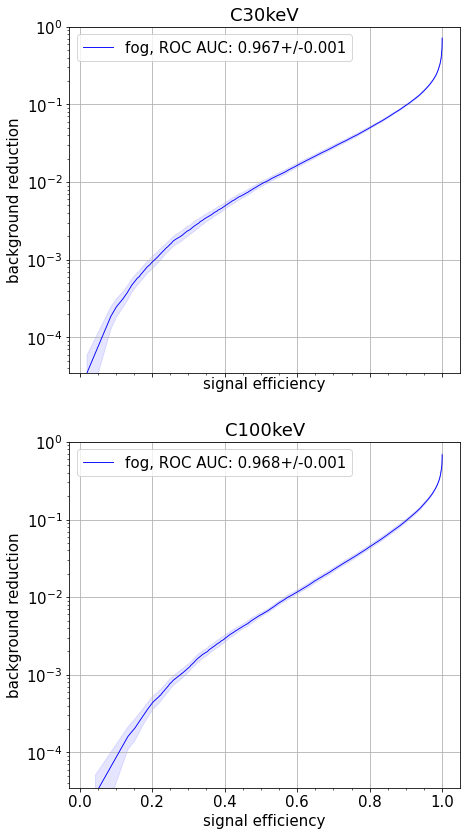

roc plots time: 0:00:23.789155


In [9]:
save_dir = '/home/scanner-ml/ML-drive/Artem/70nm/Oct2019_N123gf/plots/article/figures/no60keV/'

import scipy.interpolate
start = datetime.now()
preds = {s:[] for s in sign}
aucs = {s:[] for s in sign}
for pred_name in os.listdir('networks/predictions/'):
    pred_name = 'networks/predictions/'+pred_name
    fog_preds = np.loadtxt(pred_name)
    b = 'fog'
    for s in sign:
        mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
        preds0 = fog_preds[mask]
        y_true_sb = y_fog[mask]<n_sig_cl
        preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
        preds[s].append(preds0_sb)
        aucs[s].append(roc_auc_score(y_true_sb, preds0_sb))

# inter_curves, normal_params = {}, {}, {}
sigma_curves, mean_curves = {}, {}
for s in sign:
    preds[s] = np.array(preds[s])
#     inter_curves[s] = []
    roc_curves = []
    mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
    y_true_sb = y_fog[mask]<n_sig_cl
    for netw_preds in preds[s]:
        fpr, tpr, thr = roc_curve(y_true_sb,netw_preds)
        f_mask = fpr>0
        fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
        roc_curves.append(scipy.interpolate.interp1d(tpr, fpr, fill_value='extrapolate'))
    fpr, tpr, thr = roc_curve(y_true_sb,np.mean(preds[s], axis=0))
    f_mask = fpr>0
    fpr = fpr[f_mask]; tpr = tpr[f_mask]; thr = thr[f_mask]
    mean_pred_curve = [tpr, fpr, thr]
    inter_curves = np.zeros((ensemble_size, 2, len(mean_pred_curve[0]))) # len(mean_pred_curve[0])+1))
    for i in range(ensemble_size):
        inter_curves[i][0] = mean_pred_curve[0] # np.append([0.0],mean_pred_curve[0])
        inter_curves[i][1] = roc_curves[i](mean_pred_curve[0]) # (np.append([0.0],mean_pred_curve[0]))
#     normal_params = np.zeros((2, len(mean_pred_curve[0])))
#     normal_params[0] = np.mean(inter_curves[:,1,:], axis=0)
#     normal_params[1] = np.std(inter_curves[:,1,:], axis=0)
    
    sigma_curves[s] = np.zeros((3, len(mean_pred_curve[0]))) # np.zeros((3, len(mean_pred_curve[0])+1))
    mean_curves[s] = np.array(mean_pred_curve)
    sigma_curves[s][0] = mean_pred_curve[0] # np.append([0.0],mean_pred_curve[0])
    sigma_curves[s][1] = np.mean(inter_curves[:,1,:], axis=0)
    sigma_curves[s][2] = np.std(inter_curves[:,1,:], axis=0)*2.262/np.sqrt(ensemble_size)
    
#     print(s, np.mean((mean_curves[s][1]-sigma_curves[s][1])**2),'\n\n')
#     for j in range(inverse_curves[s].shape[-1]):
#         inverse_curves[s][:,j] = get_inverse_interval(*normal_params[:,j])
    gc.collect()

# mean_preds = {s: np.mean(preds[s], axis=0) for s in sign}
# std_preds = {s: np.std(preds[s], axis=0, ddof=1)*2.262/np.sqrt(ensemble_size) for s in sign}

# up_preds = {s: np.clip(mean_preds[s]+std_preds[s], 0,1) for s in sign}
# low_preds = {s: np.clip(mean_preds[s]-std_preds[s], 0,1) for s in sign}

mean_aucs = {s: np.mean(aucs[s]) for s in sign}
std_aucs = {s: np.std(aucs[s], ddof=1)*2.262/np.sqrt(ensemble_size) for s in sign}

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(len(sign), 1, figsize=(14//len(sign),14), sharex=True)
for j,s in enumerate(sign):
#     mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
#     y_true_sb = y_fog[mask]<n_sig_cl
#     fpr, tpr, thr = roc_curve(y_true_sb,mean_preds[s])
    i_half = np.argmin(mean_curves[s][-1]>0.993)
    print(s,'vs',b);
    print('thresh:\t',mean_curves[s][-1][i_half],'\neff:\t',mean_curves[s][0][i_half],'\nrej:\t{:.2e}'.format(mean_curves[s][1][i_half]))
    thresh_half = thr[i_half]
    
#     mask_plot = mean_curves[s][0]>0.05
    # for convenience, the main line
    tpr = sigma_curves[s][0]; fpr = sigma_curves[s][1]
#     i=0
#     while (not (fpr[mask_plot])[i]): i+=1
    #print(i,len(fpr),'\t',(fpr[mask])[i])
#     fpr = np.append([(fpr[mask_plot])[i]], (fpr[mask_plot])[i:])
#     tpr = np.append([0.05], (tpr[mask_plot])[i:])
#     sigm = np.sqrt(fpr*(1-fpr)/y_true_sb.shape[0])
#     fpr = np.append([0], fpr)
#     tpr = np.append([0], tpr)
    axes[j].plot(tpr,fpr,linewidth=0.9,color=col[b],label=b+', ROC AUC: {:.3f}+/-{:.3f}'.format(mean_aucs[s], std_aucs[s]))
    #axes[j].plot(mean_curves[s][0],mean_curves[s][1],linewidth=0.9,color='red',label=b+', BEFORE'.format(mean_aucs[s], std_aucs[s]))
    
#     fpr_up = roc_curve(y_true_sb,up_preds[s])
#     fpr_low = roc_curve(y_true_sb,low_preds[s])
    
#     if len(tpr)==len(sigma_curves[s][0]):
    sigm = np.maximum(sigma_curves[s][2], np.sqrt(fpr*(1-fpr)/preds[s].shape[1]))
    axes[j].fill( np.append(tpr,tpr[::-1]), np.append(fpr-sigm,(fpr+sigm)[::-1]), color=col[b],alpha=0.1 )
#     else:
#         axes[j].fill( np.append(tpr[1:],tpr[:0:-1]), np.append(inverse_curves[s][0],(inverse_curves[s][1])[::-1]), color=col[b],alpha=0.1 )
    
    axes[j].legend(loc=2)
    axes[j].grid()
    axes[j].minorticks_on()
    axes[j].set_xlabel('signal efficiency')
    #axes[j].set_xlim(0.05, 1.0)
    axes[j].set_ylim(3.5e-5, 1.0)
    axes[j].set_ylabel('background reduction')
    axes[j].set_yscale('log')
    axes[j].set_title(s)
        #plt.savefig('outputs/newsnet_v1/70_ncl'+str(n_cl)+'_'+rot_type+'.pdf')
#print('\n\n')
plt.savefig(save_dir+'ml_roc_vert.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()
print('roc plots time:', datetime.now()-start)

In [50]:
s = 'C60keV'
mask = np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
y_true_sb = y_fog[mask]<n_sig_cl
np.unique(y_true_sb, return_counts=True)

(array([False,  True]), array([34216, 26000]))

In [18]:
thresh_half = 0.996

sign_b = sign+['fog']
preds = {s:[] for s in sign_b}
for pred_name in os.listdir('networks/predictions/'):
    pred_name = 'networks/predictions/'+pred_name
    fog_preds = np.loadtxt(pred_name)
    b = 'fog'
    for s in sign_b:
        mask = y_fog==categ_dict[s] #np.bitwise_or(y_fog==categ_dict[b], y_fog==categ_dict[s])
        preds0 = fog_preds[mask]
        y_true_sb = y_fog[mask]<n_sig_cl
        preds0_sb = np.sum(preds0[:,:n_sig_cl],axis=1)
        preds[s].append(preds0_sb)

val_score = {}
for s in sign_b:
    preds[s] = np.array(preds[s])
    val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     if 'keV' in s:
#         val_score[s] = np.sum(preds[s]>thresh_half, axis=-1)/preds[s].shape[-1]
#     else:
#         val_score[s] = preds[s].shape[-1]/np.sum(preds[s]>thresh_half, axis=-1)

val_mean = {name: np.mean(val_score[name]) for name in sign_b}
val_std = {name: np.std(val_score[name])*2.262/np.sqrt(ensemble_size) for name in sign_b}

for name in sign_b:
    if not 'fog' in name:
        print(name, ' \t val score: {:.3f} +/- {:.3f}'.format(val_mean[name], val_std[name]))
    else:
        print(name, '\t\t val score: {:.1e} +/- {:.1e}'.format(val_mean[name], val_std[name]))

C30keV  	 val score: 0.293 +/- 0.039
C100keV  	 val score: 0.365 +/- 0.034
fog 		 val score: 2.4e-03 +/- 7.3e-04


In [9]:
start = datetime.now()
dset = '/mnt/ML-drive/Artem/Python/NEWS/colour/data/70nm/'
with h5py.File(dset+'data_ready_4.h5','r') as data_sb:
    N = data_sb['train/labels'].shape[0]
    X_tr, y_tr = data_sb['train/images'][...], data_sb['train/labels'][...]
best_kek = KerasClassifierNews(build_fn=net_create, n_cl=4, n_sig_cl=3, n_rot=6, batch_size=512, epochs=70, validation_split=3000, verbose=1, checkpoint_name='ensemble_estimators', **dict_bay_param)
best_kek.fit(X_tr, y_tr)
print('\n training time:', datetime.now()-start)

2021-09-27 00:06:30.170138: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX
2021-09-27 00:06:30.194816: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3402290000 Hz
2021-09-27 00:06:30.195453: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55d070f7ffe0 executing computations on platform Host. Devices:
2021-09-27 00:06:30.195472: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2021-09-27 00:06:30.402205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-27 00:06:30.402838: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1070 major: 6 minor: 1 memoryClockRate(GHz): 1.683
pciBusID: 


 {'n_cl': 4, 'n_sig_cl': 3, 'n_rot': 6, 'batch_size': 512, 'epochs': 70, 'validation_split': 3000, 'verbose': 1, 'checkpoint_name': 'ensemble_estimators', 'betaa1': 100.0, 'betaa2': 1500.0, 'decay': 0.015560370138015383, 'drop_end': 0.0, 'drop_middle': 0.6884329966834594, 'loss_mu': 0.01, 'lr': 0.00044557109681541026, 'n_conv2': 64, 'n_conv3': 39, 'n_resid': 2} 

Epoch 1/70


2021-09-27 00:06:49.980602: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-09-27 00:06:52.777420: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


426/426 [==============================] - 141s 331ms/step - loss: 0.4317 - val_loss: 0.7729

Epoch 00001: saving model to networks_new/checkpoints/ensemble_estimators01-0.77.h5
Epoch 2/70
426/426 [==============================] - 117s 275ms/step - loss: 0.2262 - val_loss: 0.2439

Epoch 00002: saving model to networks_new/checkpoints/ensemble_estimators02-0.24.h5
Epoch 3/70
426/426 [==============================] - 117s 276ms/step - loss: 0.1928 - val_loss: 3.6988

Epoch 00003: saving model to networks_new/checkpoints/ensemble_estimators03-3.70.h5
Epoch 4/70
426/426 [==============================] - 117s 276ms/step - loss: 0.1773 - val_loss: 0.5291

Epoch 00004: saving model to networks_new/checkpoints/ensemble_estimators04-0.53.h5
Epoch 5/70
426/426 [==============================] - 118s 276ms/step - loss: 0.1644 - val_loss: 1.5179

Epoch 00005: saving model to networks_new/checkpoints/ensemble_estimators05-1.52.h5
Epoch 6/70
426/426 [==============================] - 117s 275ms/s

In [14]:
os.listdir('networks_new/checkpoints/')

['ensemble_estimators42-1.06.h5',
 'ensemble_estimators56-0.47.h5',
 'ensemble_estimators37-0.20.h5',
 'ensemble_estimators44-0.21.h5',
 'ensemble_estimators28-0.72.h5',
 'ensemble_estimators26-0.47.h5',
 'ensemble_estimators41-0.23.h5',
 'ensemble_estimators27-0.40.h5',
 'ensemble_estimators43-0.23.h5',
 'ensemble_estimators60-0.14.h5',
 'ensemble_estimators66-0.24.h5',
 'ensemble_estimators05-1.52.h5',
 'ensemble_estimators08-0.85.h5',
 'ensemble_estimators01-0.77.h5',
 'ensemble_estimators53-0.40.h5',
 'ensemble_estimators65-1.03.h5',
 'ensemble_estimators67-0.87.h5',
 'ensemble_estimators14-0.31.h5',
 'ensemble_estimators36-0.15.h5',
 'ensemble_estimators62-0.10.h5',
 'ensemble_estimators47-0.13.h5',
 'ensemble_estimators19-0.17.h5',
 'ensemble_estimators30-0.71.h5',
 'ensemble_estimators33-1.98.h5',
 'ensemble_estimators21-0.18.h5',
 'ensemble_estimators45-0.80.h5',
 'ensemble_estimators38-0.22.h5',
 'ensemble_estimators63-0.35.h5',
 'ensemble_estimators51-0.49.h5',
 'ensemble_est

(0.0, 0.4)

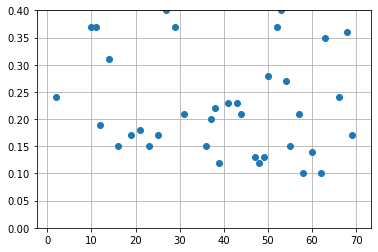

In [15]:
chp_tmp = os.listdir('networks_new/checkpoints/')
ep_tmp, loss_tmp = [],[]
for chp in chp_tmp:
    ep_tmp.append(int(chp.split('-')[0].split('tors')[1]))
    loss_tmp.append(float(chp.split('-')[1][:-3]))
plt.plot(ep_tmp, loss_tmp, 'o')
plt.grid()
plt.ylim(0,0.4)

### CARBON TEST

* saving test predictions

In [14]:
#pred_path = 'networks/predictions/'
#if not os.path.exists(pred_path):
#    os.makedirs(pred_path)
ensemble_size = 10
weight_names = os.listdir('networks_new/checkpoints/')
epochs, losses = np.zeros(len(weight_names), dtype=int), np.zeros(len(weight_names))
for i, name in enumerate(weight_names):
    epochs[i] = int(name.split('-')[0][-2:])
    losses[i] = float(name.split('-')[1][:-3])
mask_sort = np.argsort(epochs)
epochs = epochs[mask_sort]; losses = losses[mask_sort]
ensemble = []
last_ep = -1
while len(ensemble)<ensemble_size:
    if losses[last_ep]<0.25:
        chp_name = '{:02d}-{:.2f}'.format(epochs[last_ep], losses[last_ep])  #(str(epochs[last_ep]) if epochs[last_ep]>9 else '0'+str(epochs[last_ep]))
        ensemble.append('networks_new/checkpoints/ensemble_estimators'+chp_name+'.h5')
    last_ep -= 1
print(len(ensemble), ensemble)

10 ['networks_new/checkpoints/ensemble_estimators69-0.17.h5', 'networks_new/checkpoints/ensemble_estimators66-0.24.h5', 'networks_new/checkpoints/ensemble_estimators62-0.10.h5', 'networks_new/checkpoints/ensemble_estimators60-0.14.h5', 'networks_new/checkpoints/ensemble_estimators58-0.10.h5', 'networks_new/checkpoints/ensemble_estimators57-0.21.h5', 'networks_new/checkpoints/ensemble_estimators55-0.15.h5', 'networks_new/checkpoints/ensemble_estimators49-0.13.h5', 'networks_new/checkpoints/ensemble_estimators48-0.12.h5', 'networks_new/checkpoints/ensemble_estimators47-0.13.h5']


In [17]:
dset = '/mnt/ML-drive/Artem/Python/NEWS/colour/data/70nm/'
test_pred_path = 'networks_new/testC_predictions/'
n_sig_cl = 3
if not os.path.exists(test_pred_path):
    os.makedirs(test_pred_path)
test_classes = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV', 'fog']

start = datetime.now()
best_kek = net_create_2d_cpu(n_cl=4, n_sig_cl=3, n_rot=6, **dict_bay_param)
with h5py.File(dset+'data_scale_ims_col_40.h5','r') as df:
    test_preds = {name:[] for name in test_classes}
    for name in test_classes:
        print('testing ',name)
#     for name in df['test'].keys():
        start_ens = datetime.now()
        for chp_weights_name in ensemble:
            best_kek.load_weights(chp_weights_name, by_name=True)
            pred = best_kek.predict(df['test/'+name+'/images'], batch_size=512, verbose=0)
            preds_sb = np.sum(pred[:,:n_sig_cl],axis=1)#[mask]
            np.savetxt(test_pred_path+(name.split('/')[-1])+'_predict_'+(chp_weights_name.split('tors')[-1][:-3])+'.txt', preds_sb)
            test_preds[name].append(preds_sb)
            #best_kek.delete_model()
            #del best_kek
            gc.collect()
        test_preds[name] = np.array(test_preds[name])
        print('ensemble time:', datetime.now()-start_ens,'\n')
print('testing time:', datetime.now()-start,'\n')


testing  Carbon/30keV
ensemble time: 0:01:00.891949 

testing  Carbon/60keV
ensemble time: 0:01:35.743126 

testing  Carbon/100keV
ensemble time: 0:00:54.750141 

testing  fog
ensemble time: 0:00:45.980329 

testing time: 0:04:18.383014 



In [18]:
test_preds['Carbon/30keV'].shape

(10, 27565)

* loading test predictions

In [19]:
test_pred_path = 'networks_new/testC_predictions/'
test_classes = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV', 'fog']
test_preds = {name:[] for name in test_classes}
for pred_name in np.sort(os.listdir(test_pred_path)):
    name = [cl for cl in test_classes if (pred_name.split('_')[0] in cl)][0]
    pred_name = test_pred_path+pred_name
    test_preds[name].append(np.loadtxt(pred_name))
for name in test_classes:
    test_preds[name] = np.array(test_preds[name])

In [20]:
categ_dict_test = {'Carbon/30keV': 0, 'Carbon/60keV': 1, 'Carbon/100keV': 2, 'fog': 3}
sign_test = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV']

In [21]:
y_test_tot = np.hstack([np.ones(test_preds[name].shape[-1])*categ_dict_test[name] for name in test_classes])
test_preds_tot = np.hstack([test_preds[name] for name in test_classes])
print(y_test_tot.shape,'\t',test_preds_tot.shape)

(119125,) 	 (10, 119125)


In [22]:
### Test data

from IPython.utils.capture import capture_output
thresh_half = 0.999

test_classes = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV', 'fog']

test_score = {}
for name in test_classes:
#     if 'Carbon' in name:
    test_score[name] = np.sum(test_preds[name]>thresh_half, axis=-1)/test_preds[name].shape[-1]
#     else:
#         test_score[name] = test_preds[name].shape[-1]/np.sum(test_preds[name]>thresh_half, axis=-1)

test_mean = {name: np.mean(test_score[name]) for name in test_classes}
test_std = {name: np.std(test_score[name])*2.262/np.sqrt(ensemble_size) for name in test_classes}

for name in test_classes:
    if not 'fog' in name:
        print(name, '\t test score: {:.3f} +/- {:.3f}'.format(test_mean[name], test_std[name]))
    else:
        print(name, '\t\t test score: {:.1e} +/- {:.1e}'.format(test_mean[name], test_std[name]))

Carbon/30keV 	 test score: 0.023 +/- 0.024
Carbon/60keV 	 test score: 0.771 +/- 0.105
Carbon/100keV 	 test score: 0.903 +/- 0.061
fog 		 test score: 1.1e-03 +/- 1.8e-03


In [23]:
### Test data

from IPython.utils.capture import capture_output
thresh_half = 0.99

test_classes = ['Carbon/30keV', 'Carbon/60keV', 'Carbon/100keV', 'fog']

test_score = {}
for name in test_classes:
#     if 'Carbon' in name:
    test_score[name] = np.sum(np.mean(test_preds[name], axis=0)>thresh_half, axis=-1)/test_preds[name].shape[-1]
#     else:
#         test_score[name] = test_preds[name].shape[-1]/np.sum(test_preds[name]>thresh_half, axis=-1)

#test_mean = {name: np.mean(test_score[name]) for name in test_classes}
#test_std = {name: np.std(test_score[name])*2.262/np.sqrt(ensemble_size) for name in test_classes}

for name in test_classes:
    if not 'fog' in name:
        print(name, '\t test score: {:.3f}'.format(test_score[name]))# +/- {:.3f}'.format(test_mean[name], test_std[name]))
    else:
        print(name, '\t\t test score: {:.1e}'.format(test_score[name]))# +/- {:.1e}'.format(test_mean[name], test_std[name]))

Carbon/30keV 	 test score: 0.018
Carbon/60keV 	 test score: 0.763
Carbon/100keV 	 test score: 0.924
fog 		 test score: 1.4e-04
